<a href="https://colab.research.google.com/github/tozanni/covid_hacking/blob/master/COVID_Ajuste_de_parametros_con_PyMC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ajuste de parámetros del modelo SEIR (Versión probabilística)

Eduardo H. Ramirez (eduardo@ensitech.com)

Basado en la implementación de SEIR de de Miguel Núñez publicada en:

https://github.com/NunezKant/COVID-19_GDL/blob/master/Desarrollo_de_COVID_19_en_Guadalajara_Miguel_N%C3%BA%C3%B1ez.ipynb

Se basa también en el siguiente trabajo de ajuste de parámetros por mínimos cuadrados (Eduardo Ramirez)

https://colab.research.google.com/drive/1mhRUkpmttCNgTPq6DYs6xn1tF3V82q45

**Referencia PyMC3**

https://docs.pymc.io/notebooks/ODE_API_introduction.html

OJO: Requiere actualizar a PyMC 3.8


In [2]:
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

In [3]:
# El modulo ode viene en 3.8
# !pip install pymc3==3.8

### Definición de la función del modelo

El modelo es un sistema de ecuaciones diferenciales ordinarias (ODE). 

EL modelo se debe especificar en formato $f(y,t,p)$. 

In [4]:
"""
def SEIR(y, t, p):
  alpha,beta,gamma = p
  S, E, I, R = y
  ds = -beta*S*I
  de = beta*S*I - alpha*E
  di = alpha*E - gamma*I
  dr = gamma*I
  return [ds, de, di, dr]

alpha = p[0]
beta = p[1]
gamma = p[2]

S = y[0]
E = y[1]
I = y[2]

"""
## Sintaxis PyMC3 

def SEIR(y, t, p):
    ds = -p[1]*y[0]*y[2]
    de = p[1]*y[0]*y[2] - p[0]*y[1]
    di = p[0]*y[1] - p[2]*y[2]
    dr = p[2]*y[2]
    return [ds, de, di, dr]


### Generación de una corrida del modelo

El modelo depende únicamente de sus parámetros, del tiempo y de las condiciones iniciales. Aquí se muestra cómo generar una corrida para 90 días. 

In [18]:
np.random.seed(42)

alpha = 0.2
beta = 1.75
gamma = 0.5
#theta = 1.0

#params = alpha, beta, gamma
times = np.arange(0,90,1) # 90 dias
#times

## Condiciones iniciales (porcentuales)
Pop = 4225000  # ZMM
I_o = 32 / Pop  # Tenemos 32 casos
E_o = (32*4) / Pop # Asumimos 4 expuestos por caso
S_o = 1 - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

## Curva de modelo
y = odeint(SEIR,t=times,y0=[S_o,E_o,I_o,R_o], args=((alpha, beta, gamma),), rtol=1e-08)

## Curva de observaciones
#22 de Marzo: 32
#23 de Marzo: 48
#24 de Marzo: 52
#25 de Marzo: 57
#26 de Marzo: 60
#27 de Marzo: 63 (interpolación manual)
#28 de Marzo: 66
#29 de Marzo: 70 + 39 privados: 109 (pendiente)

yobs = np.array([ 32, 48, 52, 57, 60, 63, 66, 70 ])
#yobs_norm = yobs / Pop
#print([S_o,E_o,I_o,R_o]*Pop)

In [6]:
y[:5,2]*Pop

array([32.        , 42.49055202, 55.49879579, 72.14815185, 93.65416367])

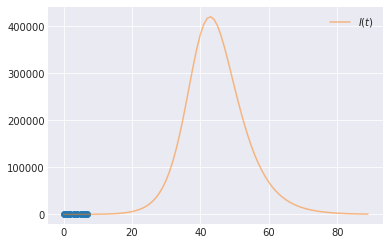

In [8]:
plt.plot(yobs, marker='o', linestyle='none')
plt.plot(times, y[:,2]*Pop, color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

Sin embargo, al mostrar el fit de las primeras 8 observaciones, notamos que la curva teórica esta bastante alejada de la línea que nos marcan las observaciones.

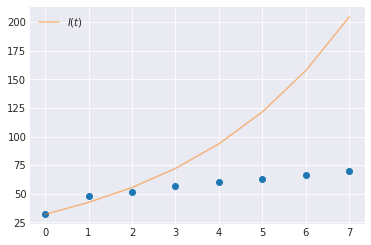

In [9]:
## Primeras 8 observaciones
plt.plot(yobs, marker='o', linestyle='none')
#plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(y[:8,2]*Pop, color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

In [20]:
# Observaciones (I)
# [ 32, 48, 52, 57, 60 ]

Pop = 4225000  # ZMM
I_o = 32 / Pop  # Tenemos 32 casos
E_o = (32*4) / Pop # Asumimos 4 expuestos por caso
S_o = 1 - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

def SEIR_Day(i,r):
  """ 
  Produce los datos normalizados de S,E,I,R dados I y R del dia.
  Los expuestos se calcula como 4 veces los infectados
  """
  I = i / Pop
  E = (i*4) / Pop # Ojo aca con el 4
  S = 1 - (E*I)
  R = r / Pop
  return [S, E, I, R]

## Crear un arreglo de N x 4 para enviar como estados al sistema
yobs_arr = np.array([ SEIR_Day(y,0) for y in yobs ])

"""
yobs = np.array([
    SEIR_Day(32,0),
    SEIR_Day(48,0),
    SEIR_Day(52,0),
    SEIR_Day(57,0),
    SEIR_Day(60,0)
  ]
)
"""
yobs_arr

array([[1.00000000e+00, 3.02958580e-05, 7.57396450e-06, 0.00000000e+00],
       [9.99999999e-01, 4.54437870e-05, 1.13609467e-05, 0.00000000e+00],
       [9.99999999e-01, 4.92307692e-05, 1.23076923e-05, 0.00000000e+00],
       [9.99999999e-01, 5.39644970e-05, 1.34911243e-05, 0.00000000e+00],
       [9.99999999e-01, 5.68047337e-05, 1.42011834e-05, 0.00000000e+00],
       [9.99999999e-01, 5.96449704e-05, 1.49112426e-05, 0.00000000e+00],
       [9.99999999e-01, 6.24852071e-05, 1.56213018e-05, 0.00000000e+00],
       [9.99999999e-01, 6.62721893e-05, 1.65680473e-05, 0.00000000e+00]])

In [22]:
obs_times=np.arange(0,yobs_arr.shape[0],1)
obs_times

array([0, 1, 2, 3, 4, 5, 6, 7])

In [103]:
## Times equiparar al yobs
seir_model = DifferentialEquation(
    func=SEIR,
    times=obs_times,
    n_states=4,
    n_theta=3,
)

INFO (theano.gof.compilelock): Refreshing lock /home/workshop/.theano/compiledir_Linux-5.0--azure-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock


In [105]:
# alpha = 0.2 , valor teorico
# gamma = 0.5 , valor teorico
# beta = 1.75 , Valor teorico para R de 3.5
# RO = 3.5  , Valor teorico para epidemia alta

with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1e-03, shape=4) #1e-3 para 4.2M de habitantes son 4.2 casos
    p_alpha = pm.Bound(pm.Normal, lower=0, upper=1)("alpha",alpha, 0.15 )  
    p_gamma = pm.Bound(pm.Normal, lower=0, upper=1)("gamma",gamma, 0.25 )  
    R0 = pm.Bound(pm.Normal, lower=1, upper=4)('R0', 3.5, 1.75)
    p_beta = pm.Deterministic('beta', p_gamma*R0)

    seir_curves = seir_model(y0=[S_o,E_o,I_o,R_o], theta=[p_alpha, p_beta, p_gamma])
    Y = pm.Normal('Y', mu=seir_curves, sd=sigma, observed=yobs_arr)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(1000,tune=500, target_accept=0.95)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

INFO (theano.gof.compilelock): Refreshing lock /home/workshop/.theano/compiledir_Linux-5.0--azure-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R0, gamma, alpha, sigma]
Sampling 4 chains, 3,460 divergences: 100%|██████████| 6000/6000 [55:42<00:00,  1.80draws/s]
There were 769 divergences after tuning. Increase `target_accept` or reparameterize.
There were 969 divergences after tuning. Increase `target_accept` or reparameterize.
There were 831 divergences after tuning. Increase `target_accept` or reparameterize.
There were 887 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 4000/4000 [00:58<00:00, 68.20it/s]


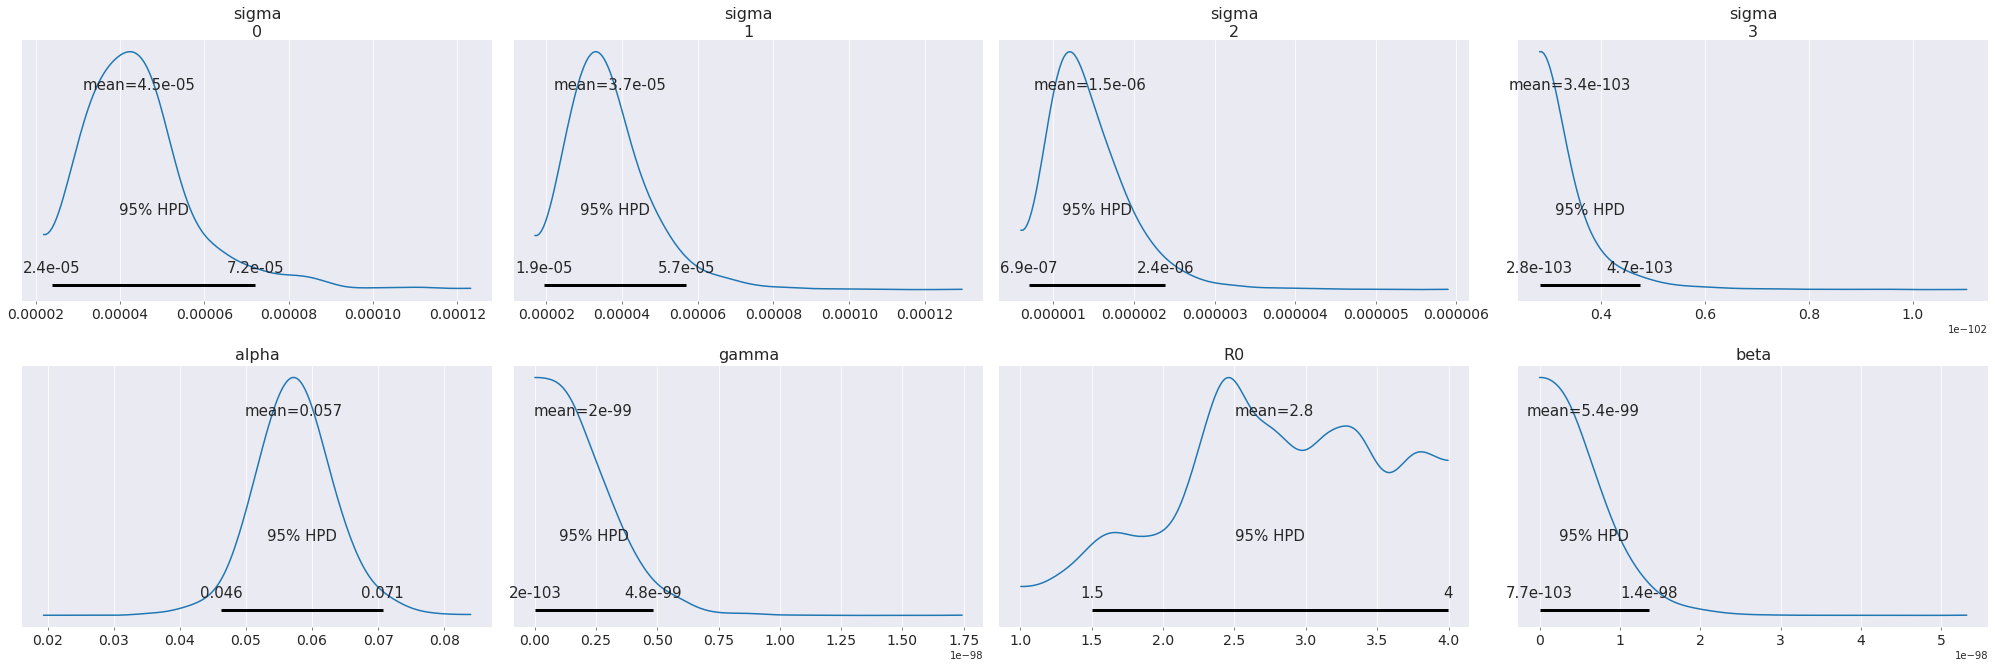

In [106]:
az.plot_posterior(data,round_to=2, credible_interval=0.95);


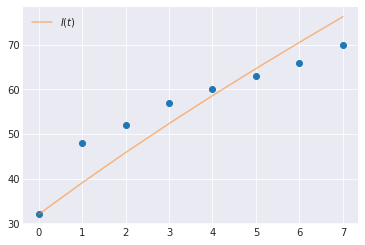

In [107]:
## Curva de modelo con parametros fiteados

times = np.arange(0,180,1) # Hay que ampliar el numero de dias

## Condiciones iniciales (porcentuales)
Pop = 4225000  # ZMM
I_o = 32 / Pop  # Tenemos 32 casos
E_o = (32*4) / Pop # Asumimos 4 expuestos por caso
S_o = 1 - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

## Curva de modelo vs. observaciones
y = odeint(SEIR,t=times,y0=[S_o,E_o,I_o,R_o], args=((0.057, 0.05, 0.002),), rtol=1e-08)

#yobs = np.array([ 32, 48, 52, 57, 60 ])

## Fit de primeras 5 observaciones
plt.plot(yobs, marker='o', linestyle='none')
#plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(y[:8,2]*Pop, color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

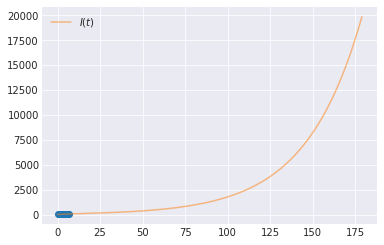

In [108]:

## Fit de primeras 5 observaciones
plt.plot(yobs, marker='o', linestyle='none')
plt.plot(times, y[:,2]*Pop, color='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

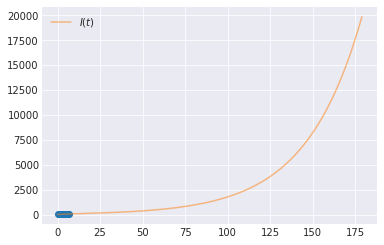

In [109]:
plt.plot(yobs, marker='o', linestyle='none')
plt.plot(times, y[:,2]*Pop, color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

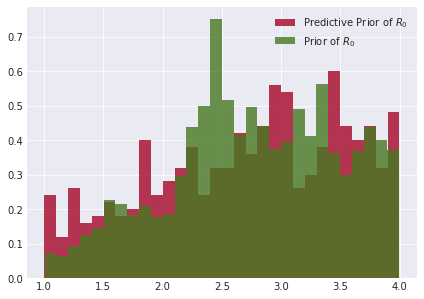

In [124]:
plt.figure(figsize = (7,5))
plt.hist(prior["R0"],histtype="stepfilled",bins=30,alpha = .80, label = f"Predictive Prior of $R_0$",color = "#A60628", density = True)
plt.hist(trace["R0"],histtype="stepfilled",bins=30,alpha = .80, label = f"Prior of $R_0$",color = "#467821", density = True)
plt.legend()

In [111]:
ppc_samples =posterior_predictive["Y"]
mean_ppc = ppc_samples.mean(axis=0)
CriL_ppc = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc = np.percentile(ppc_samples,q=97.5,axis=0)

In [112]:
ppc_samples.shape

(4000, 8, 4)

In [113]:
print(
np.mean(ppc_samples[:,:,0])*Pop,
np.mean(ppc_samples[:,:,1])*Pop,
np.mean(ppc_samples[:,:,2])*Pop,
np.mean(ppc_samples[:,:,3])*Pop
)

4224840.029595499 106.32754586720071 54.33706389074816 3.494390721143328e-97


In [114]:
np.mean(ppc_samples[:,:,2]*Pop)

54.33706389074816

(array([   5.,   11.,   51.,  331., 1420., 1614.,  472.,   74.,   19.,
           3.]), array([ 33.54426139,  41.55297733,  49.56169327,  57.57040921,
         65.57912516,  73.5878411 ,  81.59655704,  89.60527298,
         97.61398892, 105.62270486, 113.63142081]), <a list of 10 Patch objects>)

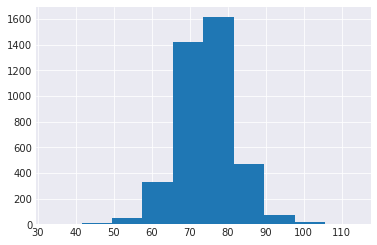

In [115]:
plt.hist(ppc_samples[:,7,2]*Pop)

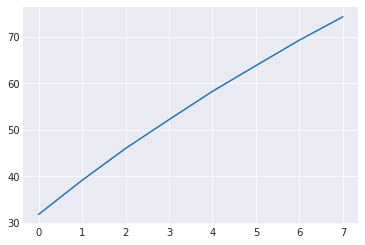

In [116]:
plt.plot(np.mean(ppc_samples[:,:,2],axis=0)*Pop)

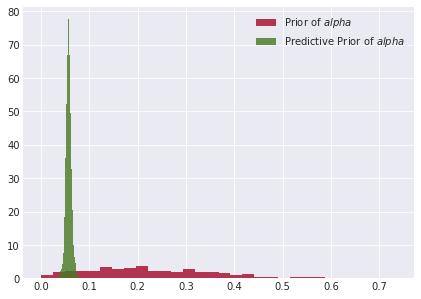

In [118]:
plt.figure(figsize = (7,5))
plt.hist(prior["alpha"],histtype="stepfilled",bins=30,alpha = .80, label = f"Prior of $alpha$",color = "#A60628", density = True)
plt.hist(trace["alpha"],histtype="stepfilled",bins=30,alpha = .80, label = f"Predictive Prior of $alpha$",color = "#467821", density = True)
plt.legend()


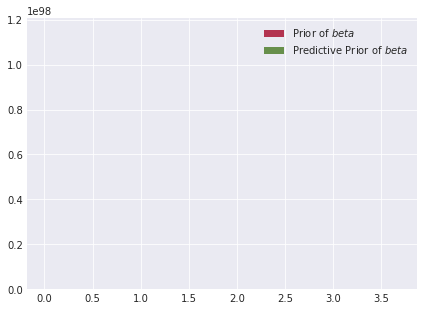

In [121]:
plt.figure(figsize = (7,5))
plt.hist(prior["beta"],histtype="stepfilled",bins=30,alpha = .80, label = f"Prior of $beta$",color = "#A60628", density = True)
plt.hist(trace["beta"],histtype="stepfilled",bins=30,alpha = .80, label = f"Predictive Prior of $beta$",color = "#467821", density = True)
plt.legend()

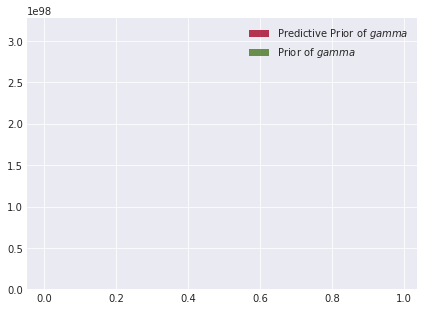

In [123]:
plt.figure(figsize = (7,5))
plt.hist(prior["gamma"],histtype="stepfilled",bins=30,alpha = .80, label = f"Predictive Prior of $gamma$",color = "#A60628", density = True)
plt.hist(trace["gamma"],histtype="stepfilled",bins=30,alpha = .80, label = f"Prior of $gamma$",color = "#467821", density = True)
plt.legend()